# "Physics-based" learning from equations: PINNs 

This notebook is an introduction to regression problems that are found when dealing with differential equations derived for (geo)physical systems. In particular, we will explore a general method that informs the machine learning model about the underlying governing equations we are trying to solve.

### 1.1 Objectives

**The goal of this notebook is to learn about physics-informed approaches and how they are implemented in practice. The student will be encouraged in particular, to play with the physics-based loss function to solve different sets of equations.**

Physics-informed neural networks (abbreviated PINNs) were first introduced in 2017 by [Raissi et al.](https://doi.org/10.1016/j.jcp.2018.10.045) as a "data-efficient universal function approximators that naturally encode any underlying physical laws as prior information". First, this means that PINNs can be used as drop-in remplacement to classical numerical solvers such as finite differences, finite volumes or spectral methods. Then, the concept of PINNs is also built on the important universal approximation theorem, which states that there always exist an architecture that approximates the target function to a certain precision. Finally, the success of PINNs also comes from its simplicity and the low (or even inexistant) data requirements. To be more precise, a PINN with parameters $\lambda$ can predict non-linear partial differential operators $\mathcal{N}(u, \lambda)$ that solves equations of the form

$$ u_{t} + \mathcal{N}(u, \lambda) = 0 $$

### 1.2 Differentiable programming (or automatic differentiation)

The algorithms explored in this notebook can be implemented with any differentiable programming framework, i.e., any library that offers automatic differentiation capabilities. Automatic differentiation can be used evaluate any partial derivative

$$ \frac{\partial u}{\partial x}\biggr|_v $$

numerically at $v$. In differs from symbolic differentiation in that it does not give a mathematical expression but a numerical value. It also differs from numerical differentiation via e.g., finite differences in that it evaluates the exact derivative and not an approximation.

In fact, automatic differentiation is the building block of backpropagation, the algorithm used by any machine learning framework which estimates the gradient of the neural network with respect to its trainable parameters.

### 1.3 Imports and configuration

In [61]:
import matplotlib.pyplot as plt
import numpy as np

import jax
import jax.numpy as jnp

import flax
import flax.linen as nn
import optax

In [62]:
%config InlineBackend.figure_formats = "svg"

### 1.4 An introduction on JAX

[JAX](https://jax.readthedocs.io/en/latest/) is "a Python library for accelerator-oriented array computation and program transformation, designed for high-performance numerical computing and large-scale machine learning". Just as PyTorch and TensorFlow, JAX gives you automatic differentiation, via program transformation (**that can be composed**). We choose JAX for this notebook, because it has been designed specifically for scientific machine learning (understand here the application of machine learning to science applications, which is largely interested in differential equations). Remember that except for some small specificities, anything implemented in this notebook is also compatible with PyTorch and TensorFlow.

**1.4.1 The JAX-numpy interface**

JAX comes with an interface that reproduces as close as possible the one from `numpy` and `scipy`, except that the functions can be run on any hardware (CPU, GPU and TPU) and support different program transformation features. Here, we have imported `jax.numpy as jnp` and we can now use any classical `numpy` functions.

In [2]:
zeros_numpy = np.zeros(10)
print(zeros_numpy)
zeros_jax = jnp.zeros(10)
print(zeros_jax)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


2024-10-24 12:21:15.438692: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 11.2 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


**1.4.2 Just-in-time compilation**

JAX cares about speed. It is built around [XLA](https://github.com/openxla/xla), a compiler based on LLVM that performs many optimization to a given code, so that it runs faster on both CPUs and GPUs. In JAX, to transform a function using on-the-fly, or just-in-time (JIT) compilation, we can just call `jax.jit` on the corresponding function.

---

*Exercise 1* : Run the following code section, then try to reduce the size `N` of the array `x`. What do you observe? Can you comment on this behavior?

In [68]:
# Compute a gaussian using NumPy (note the np.)
def gaussian_numpy(x):
  return np.exp(-x**2)
# Compute a gaussian using JAX (note the jnp.)
def gaussian_jax(x):
  return jnp.exp(-x**2)

N = 1000000

x_numpy = np.linspace(-1.0, 1.0, N)
print('Gaussian evaluation time with NumPy (CPU): ', end='')
%timeit gaussian_numpy(x_numpy)

x_jax = jnp.linspace(-1.0, 1.0, N)
print('Gaussian evaluation time with JAX (GPU): ', end='')
%timeit gaussian_jax(x_jax)

# Now, transform the function with JIT compilation
gaussian_jax_jit = jax.jit(gaussian_jax)
# JIT compilation actually happens during the first call of the function
_ = gaussian_jax_jit(x_jax) 
print('Gaussian evaluation time with JAX-JIT (GPU): ', end='')
%timeit gaussian_jax_jit(x_jax).block_until_ready()

Gaussian evaluation time with NumPy (CPU): 1.79 ms ± 10.4 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Gaussian evaluation time with JAX (GPU): 196 μs ± 5.75 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Gaussian evaluation time with JAX-JIT (GPU): 61.2 μs ± 235 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


**1.4.3 Vectorization**

An other optimization that JAX proposes is vectorization, which enables running multiple operations at the same time, most of the time in parallel. This is particularly useful when using GPUs since data transfers are expansive. In JAX, to transform a function to a vectorized version, we can just call `jax.vmap` on the corresponding function. By default, it operates on the first axis of the given function arguments.

In [69]:
# Use gaussian_jax as if it was limited to scalar arguments
def naive_batch_gaussian(x):
  return jnp.stack([gaussian_jax(x_i) for x_i in x])

N = 500
x = jnp.linspace(-1.0, 1.0, 500)

print('Naive batch with Python for loop (slow): ', end='')
%timeit naive_batch_gaussian(x).block_until_ready()

print('Batch with JAX vectorization: ', end='')
%timeit jax.vmap(gaussian_jax)(x).block_until_ready()

Naive batch with Python for loop (slow): 161 ms ± 1.25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Batch with JAX vectorization: 1.42 ms ± 14.8 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


**1.4.4 Automatic differentiation (AD)**

Finally, and most importantly, we need automatic differentiation. In mathematical terms, taking derivatives of a multivariate function is equivalent to computing the gradient of the function. In JAX, to transform a function to obtain its gradient using AD, we can just call `jax.grad` on the corresponding function. Note that `jax.grad` only support scalar-valued function.

---

*Exercise 2* : Run the following code section, then evaluate the gradiant of `gaussian_jax` at each point $x$ using `jax.vmap` vectorization.

*Exercise 3* : Compare the result of automatic differentiation with the exact Gaussian derivative $\frac{d}{dx} (\exp(-x^2)) = -2x \exp(-x^2)$ and the result from numerical differentiation with `jnp.gradient`.

In [70]:
def sum_gaussian(x):
  return jnp.sum(jnp.exp(-x**2))

x = jnp.linspace(-1.0, 1.0, 4)
print('Sum of the gaussians:',sum_gaussian(x))
# Transform the function with automatic differentiation
sum_gaussian_grad = jax.grad(sum_gaussian)
print('Gradient of the sum of gaussians with respect to x:',sum_gaussian_grad(x))

# Exercise 2
x = jnp.linspace(-1.0, 1.0, 10, endpoint=False)
derivative_gaussian_ad = jax.vmap(jax.grad(gaussian_jax))

def gaussian_derivative(x):
  return -2*x*jnp.exp(-x**2)

# Exercise 3
with jnp.printoptions(precision=2, suppress=True):
  print('Automatic differentiation:',derivative_gaussian_ad(x))
  print('Exact derivative         :',gaussian_derivative(x))
  print('Numerical derivative     :',jnp.gradient(gaussian_jax(x), 0.2))

Sum of the gaussians: 2.5254376
Gradient of the sum of gaussians with respect to x: [ 0.73575896  0.59655946 -0.5965596  -0.73575896]
Automatic differentiation: [ 0.74  0.84  0.84  0.68  0.38 -0.   -0.38 -0.68 -0.84 -0.84]
Exact derivative         : [ 0.74  0.84  0.84  0.68  0.38 -0.   -0.38 -0.68 -0.84 -0.84]
Numerical derivative     : [ 0.8   0.82  0.81  0.66  0.37 -0.   -0.37 -0.66 -0.81 -0.85]


### 1.5 A priori known information about the PDE: initial and boundary conditions

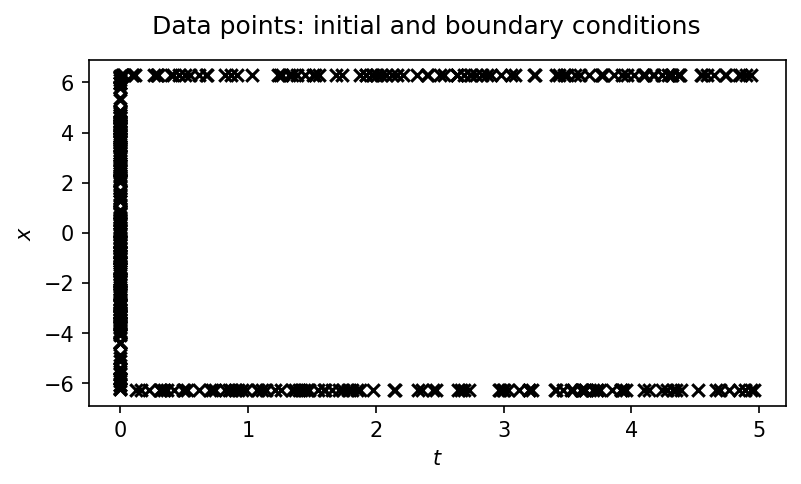

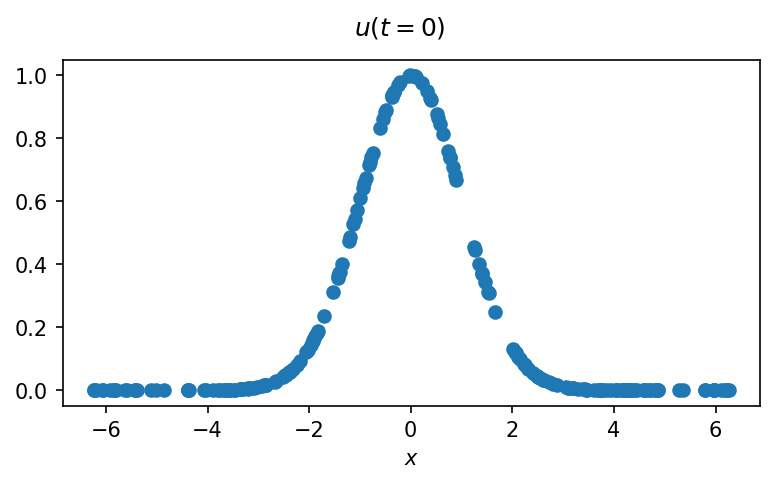

In [2]:
rng = np.random.default_rng()

def random_range(rng, size, a, b):
  return (b - a) * rng.random(size) + a

N_x = 200
N_t = 100

domain = (-2*np.pi, 2*np.pi)

lbc = 0.0
rbc = 0.0

T = 5

# N_x initial condition at t=0
t_d = np.zeros((N_x, 1))
# N_t left boundary conditions at random time
t_d = np.append(t_d, random_range(rng, N_t, 0, T))
# N_t right boundary conditions at random time
t_d = np.append(t_d, random_range(rng, N_t, 0, T))

# N_x random initial conditions position
x_d = x = random_range(rng, N_x, domain[0], domain[1])
# Left boundary position at t > 0
x_d = np.append(x_d, np.full(N_t, domain[0]))
# Right boundary position at t > 0
x_d = np.append(x_d, np.full(N_t, domain[1]))

fig, axs = plt.subplots(figsize=(6,3), dpi=150)
axs.scatter(t_d, x_d, marker='x', c='k')
axs.set_xlabel(r'$t$')
axs.set_ylabel(r'$x$')
fig.suptitle(r'Data points: initial and boundary conditions')

# u(x) at initial conditions t=0
u_d = u0 = np.exp(-x**2/2)#np.exp(-(x - 1)**2/2) - np.exp(-(x + 1)**2/2)#-np.sin(np.pi * x)
# Left boundary value u(0) at t > 0
u_d = np.append(u_d, np.full(N_t, lbc))
# Right boundary value u(0) at t > 0
u_d = np.append(u_d, np.full(N_t, rbc))

fig, axs = plt.subplots(figsize=(6,3), dpi=150)
axs.scatter(x, u0)
axs.set_xlabel(r'$x$')
fig.suptitle(r'$u(t = 0)$')
plt.show()

2024-10-15 17:34:01.622519: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 11.2 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Trainable parameters: 3441


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:51<00:00, 18.00it/s]


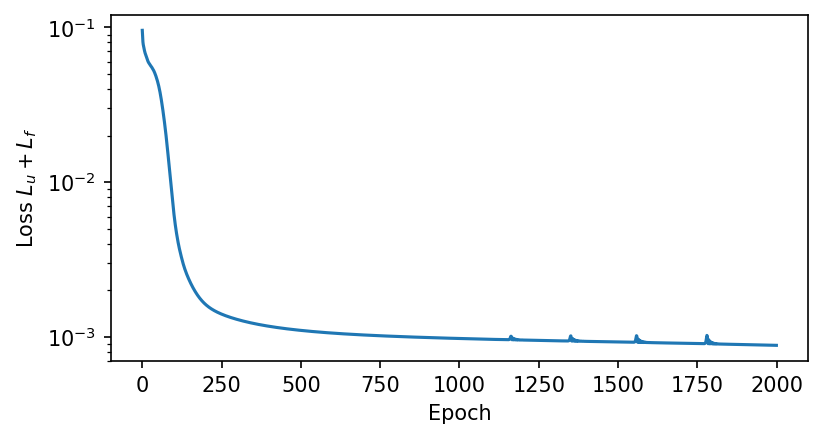

In [3]:
# sample space for PDE residuals
t_s, x_s = np.meshgrid(random_range(rng, N_t, 0, T), random_range(rng, N_x, domain[0], domain[1]))
t_s = t_s.flatten()
x_s = x_s.flatten()

def u_pred(params, t, x):
  pred = pinn.apply({'params': params}, jnp.expand_dims(jnp.array([t, x]), axis=0)).squeeze()
  return pred

def f_loss(params, t, x):
  u = u_pred(params, t, x)
  u_t = jax.grad(u_pred, argnums=1)(params, t, x)
  u_x = jax.grad(u_pred, argnums=2)(params, t, x)
  u_xx = jax.grad(jax.grad(u_pred, argnums=2), argnums=2)(params, t, x)
  f = u_t + u * u_x - (0.01/jnp.pi) * u_xx
  return f

@jax.jit
def loss(params):
  # state prediction on data points
  u = jax.vmap(u_pred, in_axes=(None, 0, 0))(params, t_d, x_d)
  l_u = jnp.mean(jnp.square(u_d - u))
  # equation residual on sample space
  f = jax.vmap(f_loss, in_axes=(None, 0, 0))(params, t_s, x_s)
  l_f = jnp.mean(jnp.square(f))
  # total loss
  return l_u + l_f

class MLP(nn.Module):
  n_blocks: int
  features: int
    
  def setup(self):
    self.blocks = [nn.Dense(self.features) for _ in range(self.n_blocks)]
    self.out = nn.Dense(1)

  def __call__(self, x):
    for block in self.blocks:
      x = block(x)
      x = nn.tanh(x)
    x = self.out(x)
    return x

pinn = MLP(n_blocks=9, features=20)

eq_train_state = flax.training.train_state.TrainState.create(params=pinn.init(jax.random.PRNGKey(42), jnp.zeros(2))['params'],
  apply_fn=pinn.apply, tx=optax.adam(learning_rate=5e-4),
)

param_count = sum(p.size for p in jax.tree_util.tree_leaves(eq_train_state.params))
print('Trainable parameters:',param_count)

epochs = 2000
epoch_loss = []
for epoch in tqdm.tqdm(range(epochs)):
  pinn_loss, grads = jax.value_and_grad(loss)(eq_train_state.params)
  eq_train_state = eq_train_state.apply_gradients(grads=grads)
  epoch_loss.append(pinn_loss)
  
fig, axs = plt.subplots(figsize=(6,3), dpi=150)
axs.semilogy(epoch_loss)
axs.set_xlabel(r'Epoch')
axs.set_ylabel(r'Loss $L_u + L_f$')
plt.show()

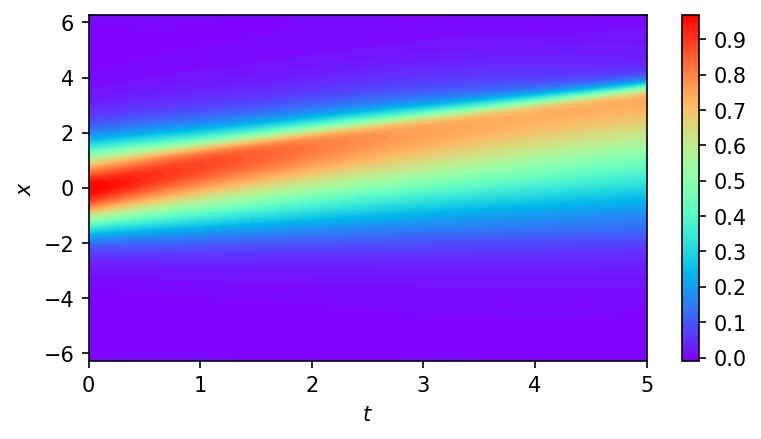

In [4]:
# Inference
t_i = np.linspace(        0,         5, N_t)
x_i = np.linspace(domain[0], domain[1], N_x)
t_prod, x_prod = np.meshgrid(t_i, x_i, indexing='ij')
t_prod = t_prod.flatten()
x_prod = x_prod.flatten()

pred_u = np.reshape(jax.vmap(u_pred, in_axes=(None, 0, 0))(eq_train_state.params, t_prod, x_prod), (N_t, N_x))

fig, axs = plt.subplots(figsize=(6,3), dpi=150)
fig.colorbar(axs.contourf(t_i, x_i, pred_u.T, levels=100, cmap='rainbow'), ax=axs)
axs.set_xlabel(r'$t$')
axs.set_ylabel(r'$x$')

plt.show()

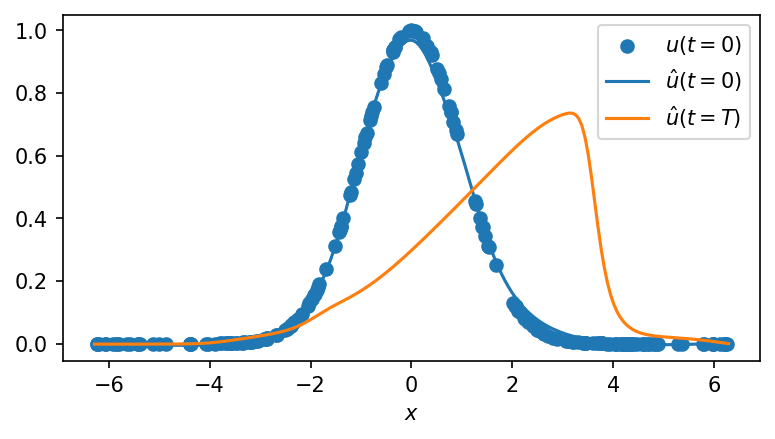

In [5]:
fig, axs = plt.subplots(figsize=(6,3), dpi=150)
axs.scatter(x, u0, label=r'$u(t = 0)$')
axs.plot(x_i, pred_u[ 0], label=r'$\hat{u}(t = 0)$')
axs.plot(x_i, pred_u[-1], label=r'$\hat{u}(t = T)$')
axs.set_xlabel(r'$x$')
axs.legend()
plt.show()